In [1]:
import glob
import numpy as np

In [2]:
coord_dir = '../data/test_data/'
coord_files = sorted(glob.glob(coord_dir + 'annotations/*.npy'))
coord_files

['../../test_data/annotations/DoG_coords.npy',
 '../../test_data/annotations/LoG_coords.npy',
 '../../test_data/annotations/PLM_coords.npy',
 '../../test_data/annotations/Polaris_coords.npy',
 '../../test_data/annotations/trackpy_coords.npy']

In [3]:
PLM_coords = np.load(coord_files[2], allow_pickle=True)
trackpy_coords = np.load(coord_files[4], allow_pickle=True)
DoG_coords = np.load(coord_files[0], allow_pickle=True)
LoG_coords = np.load(coord_files[1], allow_pickle=True)
Polaris_coords = np.load(coord_files[3], allow_pickle=True)

In [4]:
image_file = glob.glob(coord_dir + 'images/*mm*')
image_file

['../../test_data/images/20210517-mm_test_spots.npy']

In [5]:
image_stack = np.load(image_file[0])
image_stack = np.expand_dims(image_stack,axis=-1)
np.shape(image_stack)

(100, 128, 128, 1)

In [6]:
from deepcell_spots.point_metrics import *

coords_all = [PLM_coords,trackpy_coords,LoG_coords,DoG_coords,Polaris_coords]

agreement_matrix = np.zeros((len(coords_all),len(coords_all),len(coords_all[0])))

for i in range(len(coords_all)):
    agreement_matrix[i,i] = 1
    for ii in range(i+1,len(coords_all)):
        f1_score = []
        for ind in range(len(coords_all[i])):
            if len(coords_all[i][ind])==0 or len(coords_all[ii][ind])==0:
                f1_score.append(0)
                continue
            matched_points = match_points_mutual_nearest_neighbor(coords_all[i][ind],
                                                                  coords_all[ii][ind],
                                                                  threshold=1)
            match_vals = len(matched_points[0])
            unmatch_vals = (len(coords_all[i][ind])-len(matched_points[0])) + (len(coords_all[ii][ind])-len(matched_points[1]))
            f1_score.append(match_vals / (match_vals + unmatch_vals/2))
        agreement_matrix[i,ii,:] = f1_score
        agreement_matrix[ii,i,:] = f1_score

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [7]:
mean_agreement_matrix = np.zeros((len(coords_all),len(coords_all)))

for i in range(len(coords_all)):
    for ii in range(len(coords_all)):
        mean_agreement_matrix[i,ii] = np.mean(agreement_matrix[i,ii])
        mean_agreement_matrix[ii,i] = np.mean(agreement_matrix[i,ii])

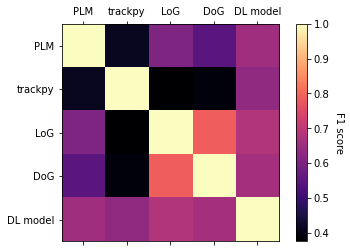

In [8]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()

im = ax.matshow(mean_agreement_matrix, cmap=plt.cm.magma)

ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(['PLM','trackpy','LoG','DoG','DL model'])
ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(['PLM','trackpy','LoG','DoG','DL model'])

cbar = ax.figure.colorbar(im)
cbar.ax.set_ylabel('F1 score', rotation=-90, va="bottom")

plt.show()

In [9]:
mean_agreement_matrix

array([[1.        , 0.4122438 , 0.60374682, 0.54676304, 0.65404877],
       [0.4122438 , 1.        , 0.37528054, 0.38849871, 0.63069945],
       [0.60374682, 0.37528054, 1.        , 0.78914284, 0.68114574],
       [0.54676304, 0.38849871, 0.78914284, 1.        , 0.66248215],
       [0.65404877, 0.63069945, 0.68114574, 0.66248215, 1.        ]])